Notebook set-up
---------------

In [1]:
# This sets plots to display in-line by default
%matplotlib inline
# Import module, for high-level functions, no additional modules are needed
import starmapper as MaP
import matplotlib.pyplot as plt
import numpy as np

# Creates an HTML button that hides/shows code cells
# Useful for lab notebook reports and research updates
# NOTE: this does not display well on GitHub.
MaP.create_code_button()

compct data not found in rnp_example


C:\Users\psirv\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


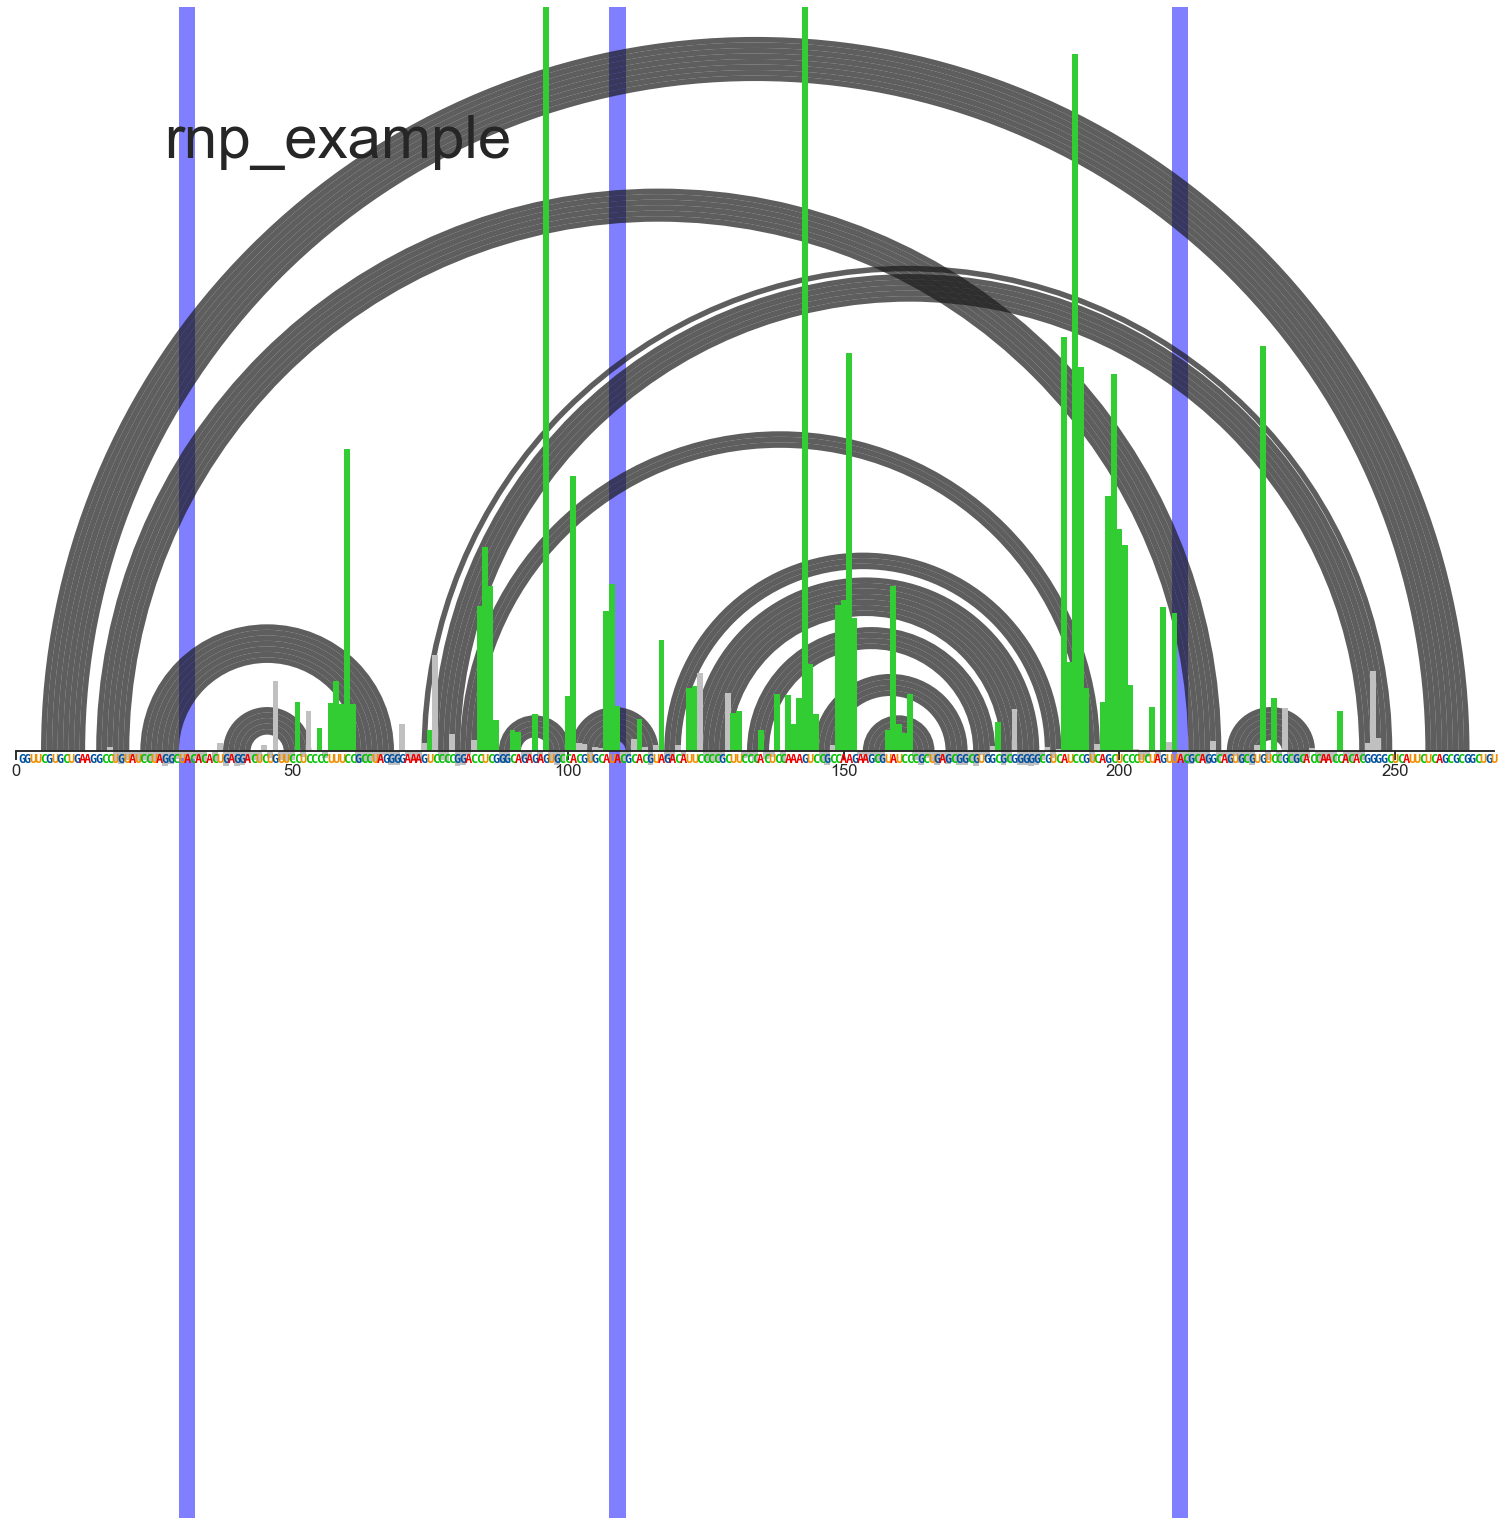

In [2]:
rnp_sample = MaP.Sample(sample="rnp_example",
                        rnp="data/RMRP-RNPMaP-Example_RESULTS.csv",
                        ss="data/hs-RMRP.nsd")
ss = rnp_sample.make_ap(ct="ss", profile="rnp")
annotation = MaP.Annotation(name="TAC", motif="UAC", color="blue",
                            sequence=rnp_sample.data["ss"].sequence)
xvals = np.array(rnp_sample.data["ss"].num)/rnp_sample.data["ss"].length
yvals = np.array([int(site) for site in annotation.sites])
ss.axes[0,0].bar(xvals, yvals, 1/rnp_sample.data["ss"].length, linewidth=0,
                 alpha=0.5, color=annotation.color, zorder=-5,
                 transform=ss.axes[0, 0].transAxes);

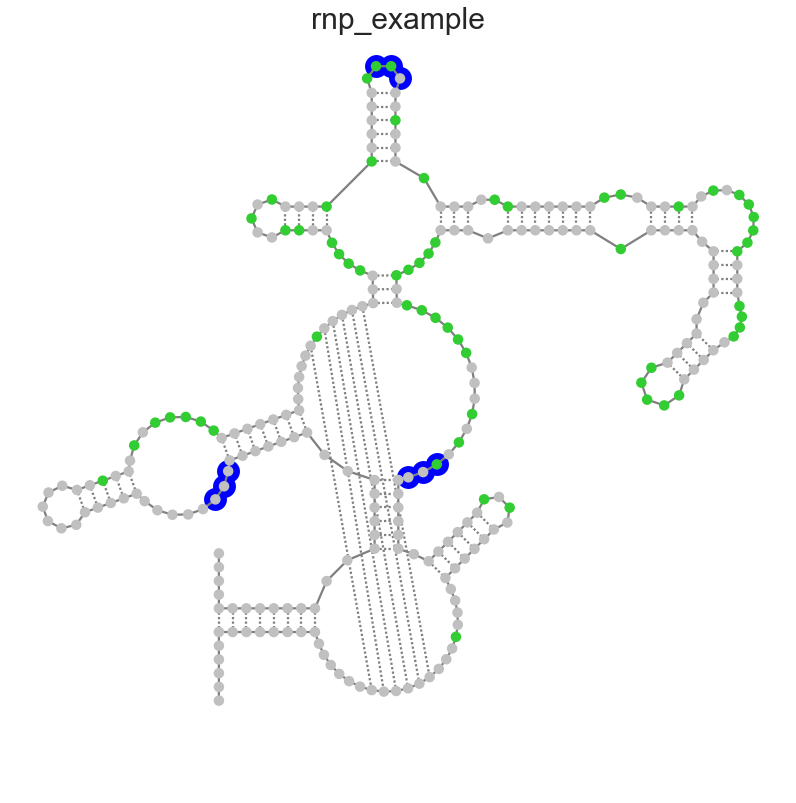

In [3]:
ss = rnp_sample.make_ss(profile="rnp")
annotation = MaP.Annotation(name="TAC", motif="UAC", color="blue",
                            sequence=rnp_sample.data["ss"].sequence)
xvals = rnp_sample.data["ss"].xcoordinates[annotation.sites]
yvals = rnp_sample.data["ss"].ycoordinates[annotation.sites]
ss.axes[0, 0].scatter(xvals, yvals, s=525, linewidth=0, color=annotation.color, zorder=-5)


Initializing MaP sample
-----------------------

In [4]:
path = 'data/'
def kwargs(sample):
    kwargs = {"sample": sample,
              "profile": path+sample+"_rnasep_profile.txt",
              "ct": path+"RNaseP.ct",
              "ss": path+"RC_CRYSTAL_STRUCTURE.xrna",
              "rings": path+sample+"-rnasep.corrs",
              "pairs": path+sample+"-rnasep-pairmap.txt",
              "log": path+sample+"_shapemapper_log.txt",
              "dance_prefix": path+sample+"_rnasep",
              "deletions": path+"example-rnasep-deletions.txt",
              "fasta": path+"RNaseP-noSC.fasta",
              "pdb": path+"3dhs_Correct.pdb",
              "pdb_kwargs":{"chain": "A"}}
    return kwargs

example1 = MaP.Sample(**kwargs("example1"))
example2 = MaP.Sample(**kwargs("example2"))
example3 = MaP.Sample(**kwargs("example3"))
example4 = MaP.Sample(**kwargs("example4"))
samples = [example1, example2, example3, example4]

In [5]:
def dist_hist(sample, ij, cdAbove=15):
    # make list of all distances based on pdb
    matrix = sample.data["pdb"].get_distance_matrix()
    cd_matrix = sample.data["ct"].get_distance_matrix() > cdAbove
    pdb_dists = []
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if i > 17 and i+6 < j and j < 316 and cd_matrix[i, j] and matrix[i, j] != 1000:
                pdb_dists.append(matrix.item(i, j))

    #make list of rings distances
    sample.data[ij].set_3d_distances(sample.data["pdb"])
    ij_dists = {}
    stat_cutoffs = [50, 100, 500]
    # DataFrame.rank(axis=0, method='average', numeric_only=NoDefault.no_default, na_option='keep', ascending=True, pct=False)
    for stat in stat_cutoffs:
        sample.data[ij].filter(
            sample.data["pdb"], ct=sample.data["ct"], cdAbove=cdAbove, Statistic=stat, Sign=0)
        mask = sample.data[ij].data["mask"]
        ij_dists[stat] = sample.data[ij].data.loc[mask, "Distance"]
        # remove no data
        # ij_dists[stat] = [x for x in ij_dists if x != 1000]

    fig, ax = plt.subplots(1, figsize=(7, 7))
    ax2 = ax.twinx()
    for x in stat_cutoffs:
        ax.hist(ij_dists[x], bins=range(0, 200, 5), label=f"MI > {x}")
    ax.set_title(sample.sample)
    ax2.hist(pdb_dists, bins=range(0, 200, 5), histtype='step',
             color="black", label="All distances")


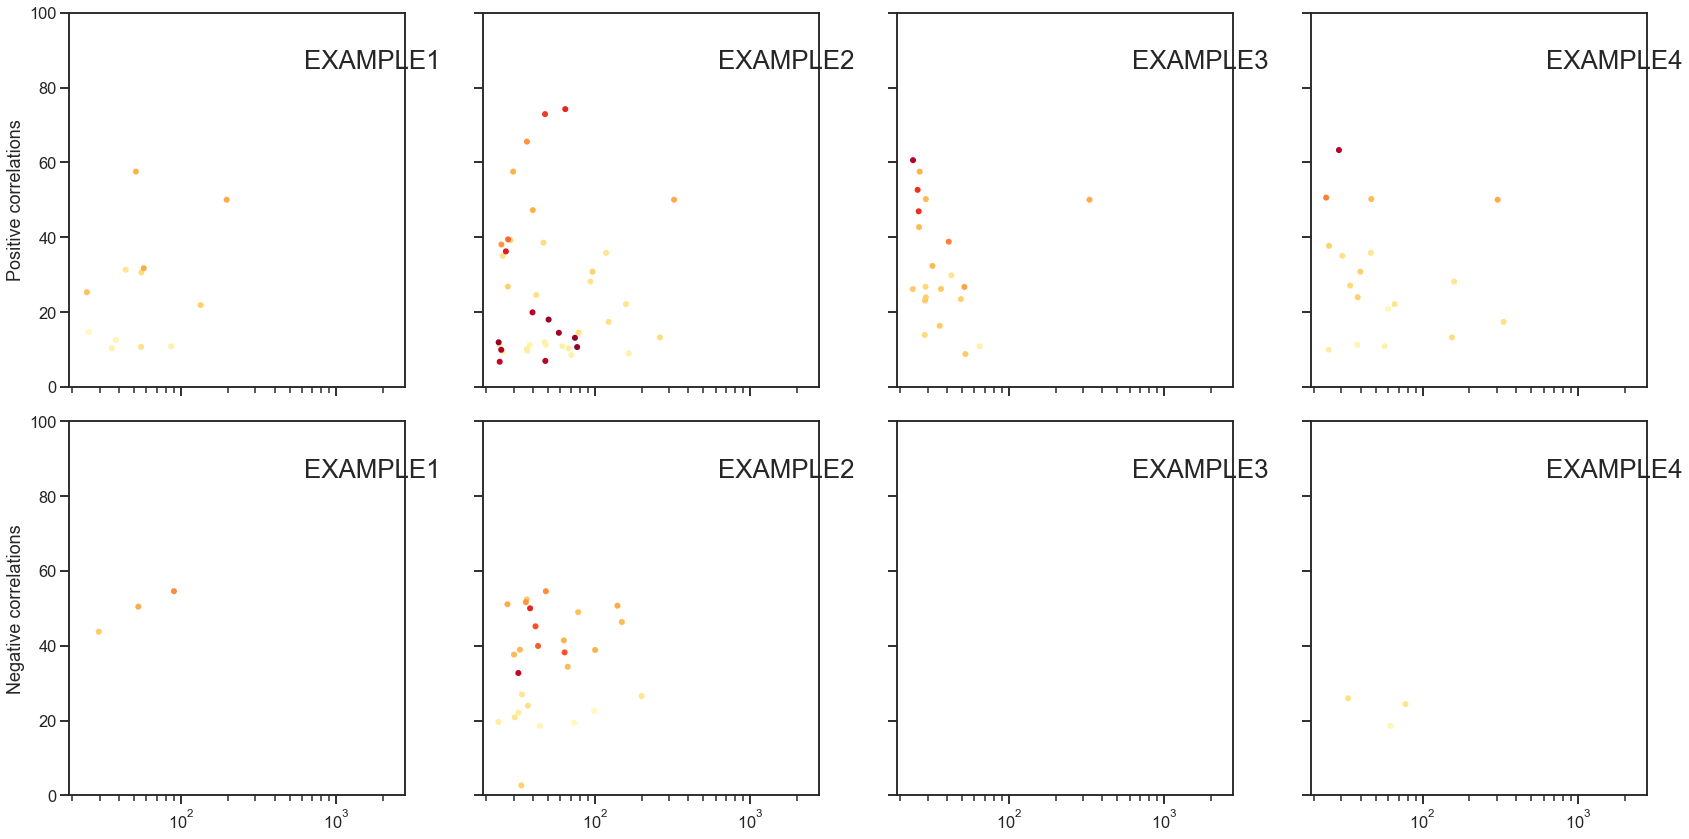

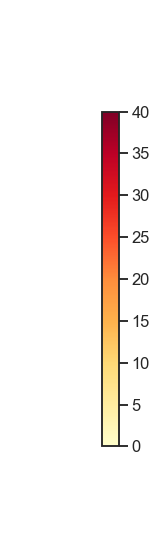

In [6]:
fig, ax = plt.subplots(2, 4, figsize=(24, 12), sharey=True, sharex=True)
for i, sample in enumerate(samples):
    sample.data["rings"].set_3d_distances(sample.data["pdb"])
    data = sample.data["rings"].data
    data["cd"] = [sample.data["ct"].contactDistance(
        i+1, j+1) for _, i, j in data[["i", "j"]].itertuples()]
    data.sort_values(by=["cd"], inplace=True)
    mask = data["Sign"] == 1
    im = ax[0, i].scatter(data.loc[mask, "Statistic"], data.loc[mask, "Distance"],
                          c=data.loc[mask, "cd"], cmap="YlOrRd", marker='.', vmin=0, vmax=40)
    ax[0, i].annotate(sample.sample[:].upper(), (0.7, 0.85),
                      xycoords="axes fraction", fontsize="x-large")
    ax[1, i].annotate(sample.sample[:].upper(), (0.7, 0.85),
                      xycoords="axes fraction", fontsize="x-large")
    ax[1, i].scatter(data.loc[~mask, "Statistic"], data.loc[~mask, "Distance"],
                     c=data.loc[~mask, "cd"], cmap="YlOrRd", marker='.', vmin=0, vmax=40)
ax[0, 0].set(xscale="log", ylim=[0,100])
ax[0, 0].set_ylabel("Positive correlations")
ax[1, 0].set_ylabel("Negative correlations")
plt.tight_layout()

fig, ax = plt.subplots(1, figsize=(2, 10))
fig.colorbar(im, ax=ax)
ax.set_axis_off()
